#UAS

## 📊 Data Understanding - Cervical Cancer Risk Factors

Dataset ini berisi informasi terkait faktor risiko kanker serviks pada wanita. Sumber data berasal dari repository UCI Machine Learning dan mencakup berbagai atribut medis, kebiasaan hidup, serta hasil diagnosis klinis.

### 🔍 1. Informasi Umum Dataset

- **Jumlah Baris**: 858
- **Jumlah Kolom**: 36 (termasuk target)
- **Format File**: CSV
- **Nilai Missing**: Diwakili dengan karakter `?`, yang telah dikonversi menjadi `NaN`

### 📌 2. Penjelasan Fitur

Beberapa fitur penting dalam dataset ini antara lain:

| Kolom                            | Deskripsi                                                                 |
|----------------------------------|---------------------------------------------------------------------------|
| `Age`                            | Usia responden dalam tahun                                                |
| `Number of sexual partners`      | Jumlah pasangan seksual                                                   |
| `First sexual intercourse`       | Usia saat pertama kali berhubungan seksual                                |
| `Num of pregnancies`             | Jumlah kehamilan                                                          |
| `Smokes`                         | Apakah responden merokok                                                  |
| `Smokes (years)`                 | Berapa tahun merokok                                                      |
| `Smokes (packs/year)`           | Jumlah pack per tahun                                                     |
| `Hormonal Contraceptives`       | Penggunaan kontrasepsi hormonal                                           |
| `Hormonal Contraceptives (years)`| Lama penggunaan kontrasepsi hormonal                                     |
| `IUD`                            | Penggunaan IUD (Intrauterine Device)                                      |
| `STDs`, `STDs:condylomatosis`, ...| Informasi tentang penyakit menular seksual (tipe spesifik)               |
| `STDs: Time since first diagnosis` | Lama sejak pertama kali didiagnosis STD                                 |
| `Biopsy` *(Target)*             | Hasil biopsy (0 = Negatif, 1 = Positif kanker serviks)                    |

> ⚠️ Catatan: Banyak fitur bertipe numerik tetapi sebenarnya bersifat kategorikal (contoh: 0/1 untuk ya/tidak).

### 🧼 3. Data Cleaning

- Missing values diimputasi menggunakan strategi **median** untuk fitur numerik.
- Fitur `Age` dikategorikan ke dalam **kelompok usia**:
  - `Teen`: < 20 tahun
  - `20s`: 20-29
  - `30s`: 30-39
  - `40s`: 40-49
  - `50+`: ≥ 50

### ⚙️ 4. Feature Engineering

Fitur baru yang dibuat untuk membantu model memahami konteks data:

- `Age_Group`: Kategori usia
- `First_Sex_Age`: Disalin dari `First sexual intercourse`
- `HPV_Exposure_Duration`: `Age` - `First sexual intercourse`
- `Pregnancy_Density`: Jumlah kehamilan dibagi umur reproduksi aktif (`Age - 12`), sebagai indikator intensitas kehamilan

### ⚖️ 5. Distribusi Kelas Target

```python
# Visualisasi distribusi target
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Biopsy', data=data)
plt.title('Distribusi Kelas Target (Biopsy)')
plt.xlabel('Hasil Biopsi (0 = Negatif, 1 = Positif)')
plt.ylabel('Jumlah')
plt.show()


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [39]:
# 1. Load Data
data = pd.read_csv('risk_factors_cervical_cancer.csv', na_values='?')

In [40]:
 #2. Preprocessing Awal
# Handle missing values untuk data numerik
numeric_cols = data.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='median')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

In [41]:
# 3. Feature Engineering
# Kelompokkan usia
data['Age_Group'] = pd.cut(data['Age'],
                          bins=[0, 20, 30, 40, 50, 100],
                          labels=['Teen', '20s', '30s', '40s', '50+'])

# Buat fitur baru
data['First_Sex_Age'] = data['First sexual intercourse']
data['HPV_Exposure_Duration'] = data['Age'] - data['First sexual intercourse']
data['Pregnancy_Density'] = data['Num of pregnancies'] / (data['Age'] - 12).clip(lower=1)  # Hindari pembagi 0

In [42]:
# 4. Persiapan Data untuk Modelling
# Definisikan kolom target
y = data['Biopsy'].astype(int)

# Definisikan kolom fitur
X = data.drop(['Biopsy', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology'], axis=1)

# Pisahkan kolom numerik dan kategorik
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ['Age_Group']

# Preprocessor untuk kolom berbeda
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [43]:
# 5. SMOTE untuk Handling Class Imbalance
print("\n=== Class Distribution ===")
print(y.value_counts())


=== Class Distribution ===
Biopsy
0    803
1     55
Name: count, dtype: int64


In [44]:
# 6. Modelling dengan Pipeline dan Hyperparameter Tuning
pipelines = {
    'Naive Bayes': ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', SMOTE(random_state=42)),
        ('classifier', GaussianNB())
    ]),

    'Decision Tree': ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', SMOTE(random_state=42)),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),

    'Random Forest': ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}

In [45]:
# Hyperparameter grids
param_grids = {
    'Naive Bayes': {},

    'Decision Tree': {
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__criterion': ['gini', 'entropy']
    },

    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__class_weight': ['balanced', None]
    }
}

In [46]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [47]:
# Latih dan tuning model
best_models = {}
for name in pipelines.keys():
    print(f"\n=== Tuning {name} ===")
    grid_search = GridSearchCV(
        estimator=pipelines[name],
        param_grid=param_grids[name],
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    best_models[name] = {
        'model': grid_search.best_estimator_,
        'params': grid_search.best_params_,
        'score': grid_search.best_score_
    }

    print(f"Best params: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_:.4f}")


=== Tuning Naive Bayes ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params: {}
Best F1 score: 0.1158

=== Tuning Decision Tree ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_split': 2}
Best F1 score: 0.1648

=== Tuning Random Forest ===
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 15, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best F1 score: 0.1533


In [48]:
# 7. Evaluasi Model Terbaik
print("\n=== Final Model Evaluation ===")
best_model_name = None
best_f1 = 0
results = {}

for name, model_info in best_models.items():
    model = model_info['model']
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results[name] = {
        'accuracy': acc,
        'f1': f1,
        'confusion': cm,
        'report': report
    }

    print(f"\n{name} Performance:")
    print(f"Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name

print(f"\nBest Model: {best_model_name} with F1-Score {best_f1:.4f}")



=== Final Model Evaluation ===

Naive Bayes Performance:
Accuracy: 0.0930, F1-Score: 0.1269
Confusion Matrix:
[[  7 234]
 [  0  17]]

Decision Tree Performance:
Accuracy: 0.8450, F1-Score: 0.1304
Confusion Matrix:
[[215  26]
 [ 14   3]]

Random Forest Performance:
Accuracy: 0.9186, F1-Score: 0.1600
Confusion Matrix:
[[235   6]
 [ 15   2]]

Best Model: Random Forest with F1-Score 0.1600


In [49]:
# 8. Visualisasi Model Terbaik
print("\n=== Visualisasi Model Terbaik ===")
best_model_info = best_models[best_model_name]
best_model = best_model_info['model']

# Prediksi probabilitas untuk plotting kurva
y_pred_proba = best_model.predict_proba(X_test)[:, 1]


=== Visualisasi Model Terbaik ===


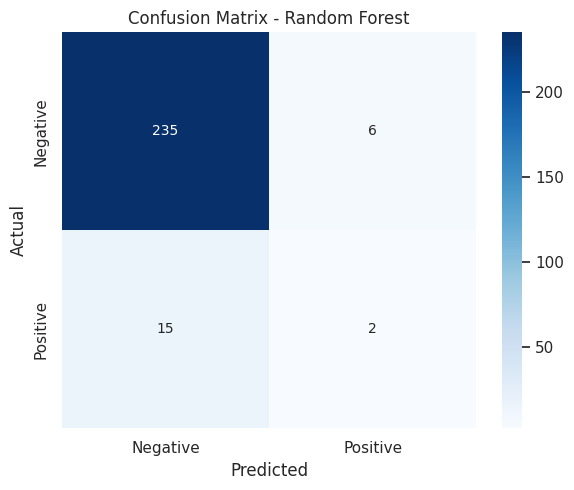

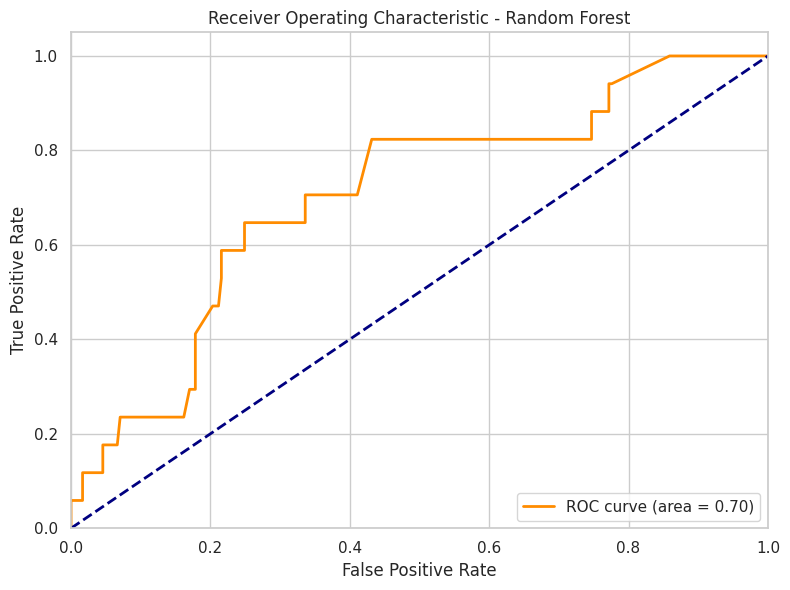

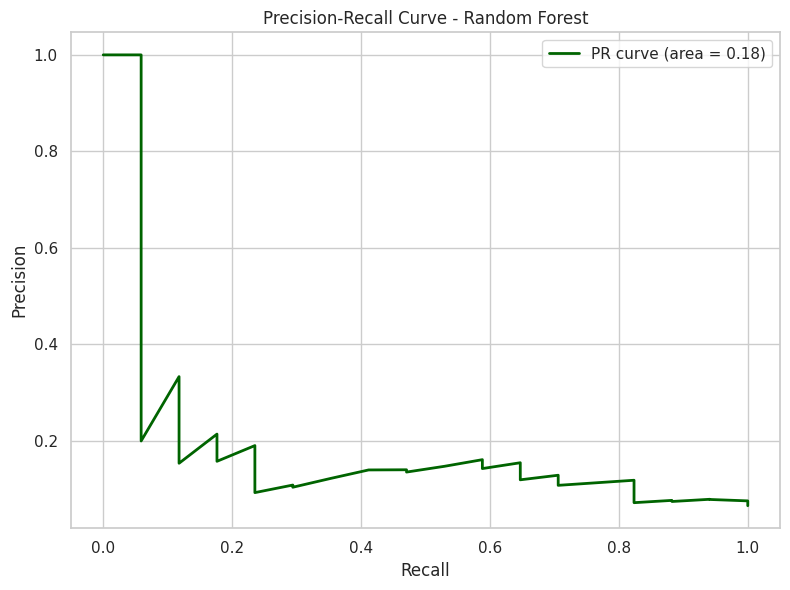


=== Feature Importance ===


/tmp/ipython-input-50-2243470580.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


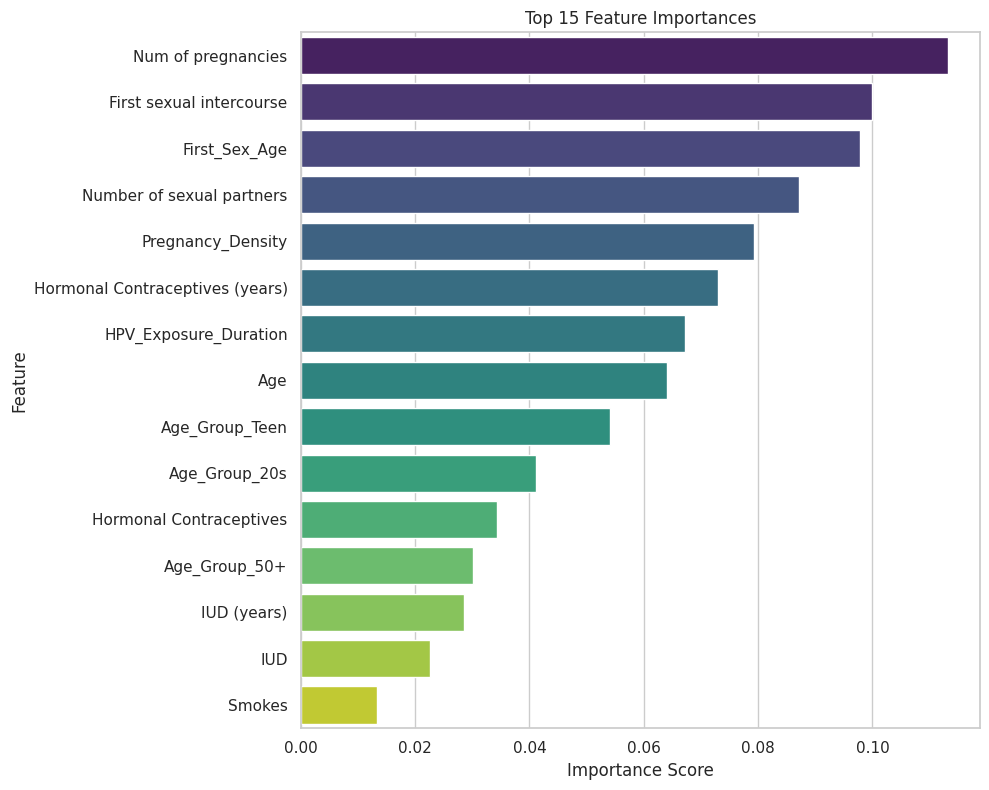

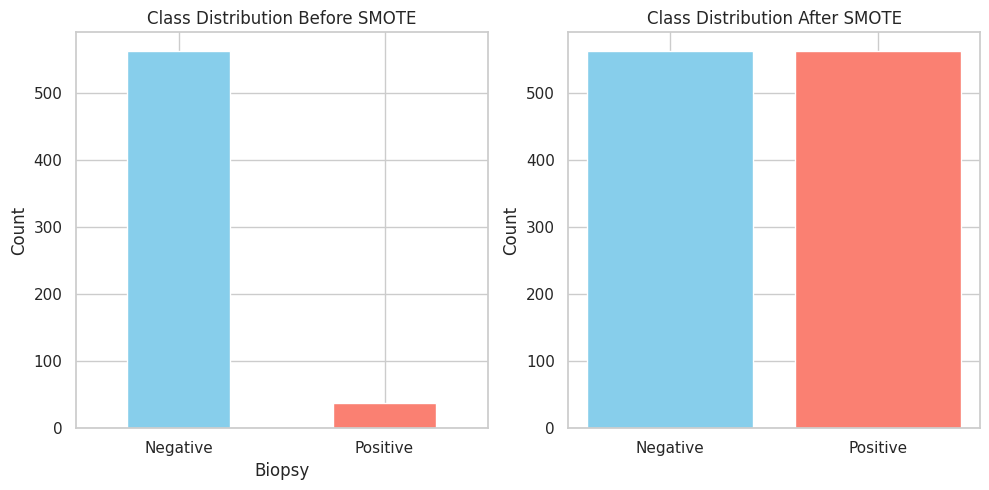

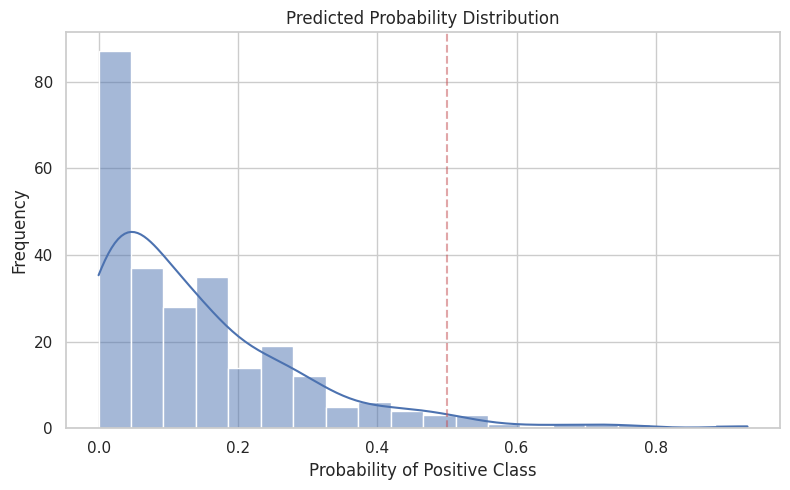


Visualisasi telah disimpan sebagai file PNG


In [50]:
# A. Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# B. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic - {best_model_name}')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()

# C. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkgreen', lw=2,
         label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name}')
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig('precision_recall_curve.png')
plt.show()

# D. Feature Importance (khusus untuk tree-based models)
if best_model_name in ['Decision Tree', 'Random Forest']:
    print("\n=== Feature Importance ===")

    # Dapatkan classifier dari pipeline
    classifier = best_model.named_steps['classifier']

    # Dapatkan feature importances
    importances = classifier.feature_importances_

    # Dapatkan nama fitur setelah preprocessing
    # Untuk kolom numerik
    feature_names = list(numeric_features)

    # Untuk kolom kategorik (Age_Group)
    # Kita tahu bahwa Age_Group di-encode menjadi beberapa kolom
    age_groups = ['Teen', '20s', '30s', '40s', '50+']
    age_group_features = [f'Age_Group_{group}' for group in age_groups]
    feature_names.extend(age_group_features)

    # Pastikan jumlah fitur sesuai
    if len(importances) != len(feature_names):
        # Jika tidak sesuai, gunakan placeholder
        feature_names = [f'Feature_{i}' for i in range(len(importances))]

    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(15)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    # Simpan feature importance ke file
    feature_importances.to_csv('feature_importances.csv', index=False)

# E. Class Distribution Comparison
plt.figure(figsize=(10, 5))

# Sebelum SMOTE
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution Before SMOTE')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
plt.ylabel('Count')

# Setelah SMOTE (kita tahu jumlahnya seimbang)
plt.subplot(1, 2, 2)
balanced_count = max(y_train.value_counts())  # Jumlah sampel setelah SMOTE
plt.bar([0, 1], [balanced_count, balanced_count], color=['skyblue', 'salmon'])
plt.title('Class Distribution After SMOTE')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# F. Prediction Distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred_proba, bins=20, kde=True)
plt.axvline(0.5, color='r', linestyle='--', alpha=0.5)
plt.title('Predicted Probability Distribution')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('prediction_distribution.png')
plt.show()

print("\nVisualisasi telah disimpan sebagai file PNG")
